<a href="https://colab.research.google.com/github/ishikaww/SIH-plankton/blob/main/resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install fastai

In [25]:
from fastai.vision import *

In [26]:
from roboflow import Roboflow

rf = Roboflow(api_key="gfPvlcLH3epGBoxMjbwE")
project = rf.workspace("dehydratedaf").project("carbonate-image-classification-tkhgt")
dataset = project.version(1).download("folder")


loading Roboflow workspace...
loading Roboflow project...


In [27]:
dataset.location

'/content/Carbonate-Image-Classification-1'

In [28]:
import numpy as np
from pathlib import Path
from fastai.vision.all import *

# Set seed for reproducibility
np.random.seed(42)

# Point to Roboflow dataset location
path = Path(dataset.location)

# Data with strong augmentation
data = ImageDataLoaders.from_folder(
    path,
    train="train",
    valid="valid",
    seed=42,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(
        mult=2.0,
        do_flip=True,
        flip_vert=True,
        max_rotate=25,
        max_zoom=1.2,
        max_warp=0.2,
        p_affine=0.9,
        p_lighting=0.9
    )
)


print("Classes:", data.vocab)


Classes: ['benthic foraminifera', 'bivalve', 'brachiopod', 'bryozoan', 'cephalopod', 'crinoid', 'echinoid', 'gastropod', 'green algae', 'ostracod', 'plankton foraminifera', 'red algae', 'rugose coral', 'scleractinian coral', 'sponges']


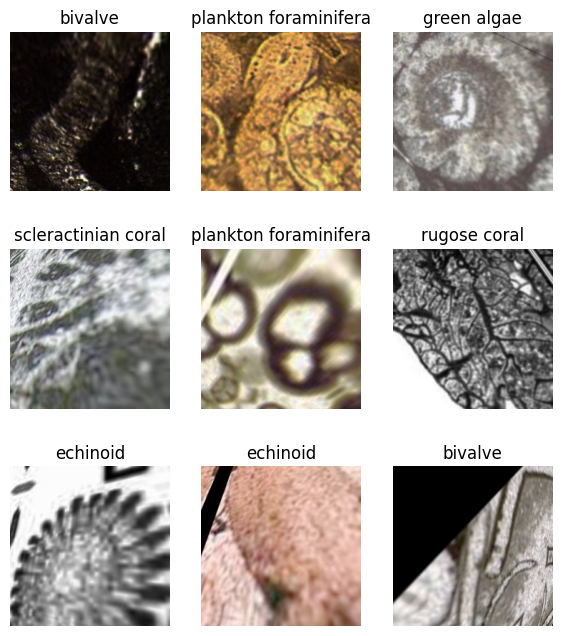

In [29]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(nrows=3, figsize=(7, 8))


In [35]:
from fastai.vision.all import *

# build a ResNet34 learner
learn = vision_learner(
    data,
    resnet50,
    metrics=accuracy,
    wd=1e-4,   # weight decay
    ps=0.5     # dropout prob
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 91.1MB/s]


SuggestedLRs(valley=0.0010000000474974513)

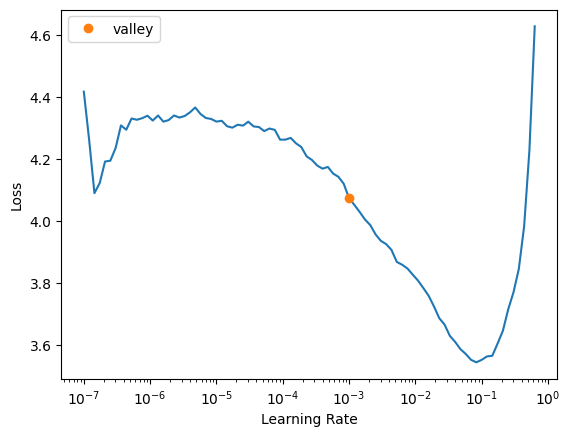

In [36]:
learn.lr_find()


In [31]:
#print network layers
learn

In [32]:
learn.model


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [33]:
learn.summary()


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [37]:
from fastai.callback.tracker import SaveModelCallback


learn.fine_tune(
    30,                          # train for up to 30 epochs
    base_lr=1e-3,                # from lr_find suggestion
    cbs=[SaveModelCallback(fname="best_resnet50")]
)



epoch,train_loss,valid_loss,accuracy,time
0,3.389371,2.217141,0.377551,00:24


Better model found at epoch 0 with valid_loss value: 2.2171413898468018.


epoch,train_loss,valid_loss,accuracy,time
0,2.465863,1.919823,0.435374,00:34
1,2.343403,1.847167,0.465986,00:31
2,2.162786,1.683092,0.486395,00:32
3,2.009423,1.609593,0.540816,00:32
4,1.865059,1.550395,0.557823,00:32
5,1.691954,1.496661,0.564626,00:32
6,1.526478,1.438189,0.574830,00:32
7,1.365601,1.434392,0.574830,00:32
8,1.199971,1.397699,0.615646,00:32
9,1.088285,1.362828,0.585034,00:32


Better model found at epoch 0 with valid_loss value: 1.9198228120803833.
Better model found at epoch 1 with valid_loss value: 1.8471671342849731.
Better model found at epoch 2 with valid_loss value: 1.683091640472412.
Better model found at epoch 3 with valid_loss value: 1.6095926761627197.
Better model found at epoch 4 with valid_loss value: 1.550394892692566.
Better model found at epoch 5 with valid_loss value: 1.4966607093811035.
Better model found at epoch 6 with valid_loss value: 1.438188910484314.
Better model found at epoch 7 with valid_loss value: 1.434391975402832.
Better model found at epoch 8 with valid_loss value: 1.3976994752883911.
Better model found at epoch 9 with valid_loss value: 1.3628278970718384.
Better model found at epoch 10 with valid_loss value: 1.2817150354385376.
Better model found at epoch 12 with valid_loss value: 1.2637485265731812.
Better model found at epoch 13 with valid_loss value: 1.227808952331543.
Better model found at epoch 14 with valid_loss value:

In [38]:
learn.export("best_model_export.pkl")
print("✅ Model exported as best_model_export.pkl")

✅ Model exported as best_model_export.pkl


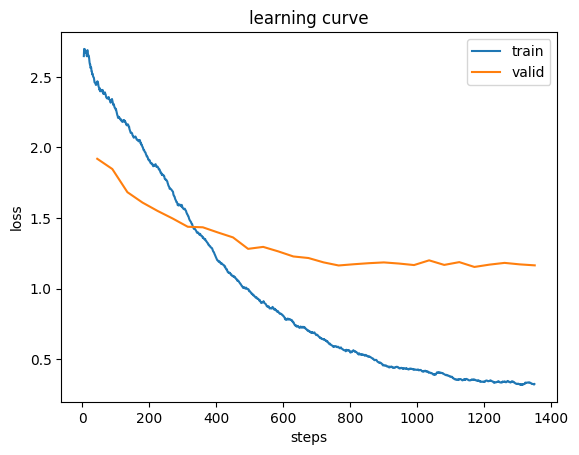

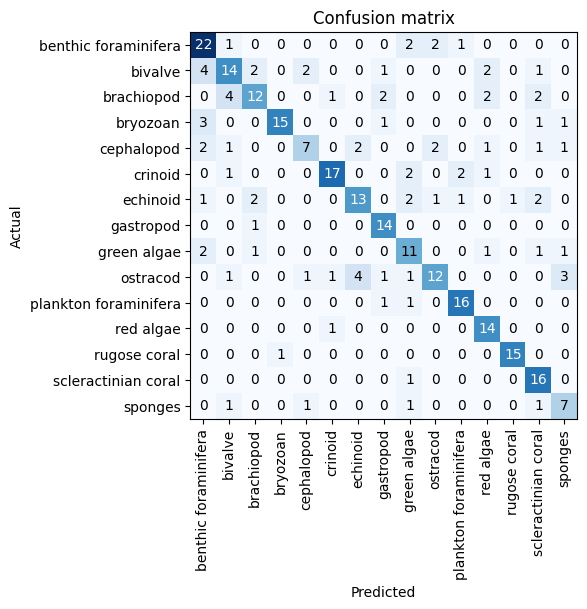

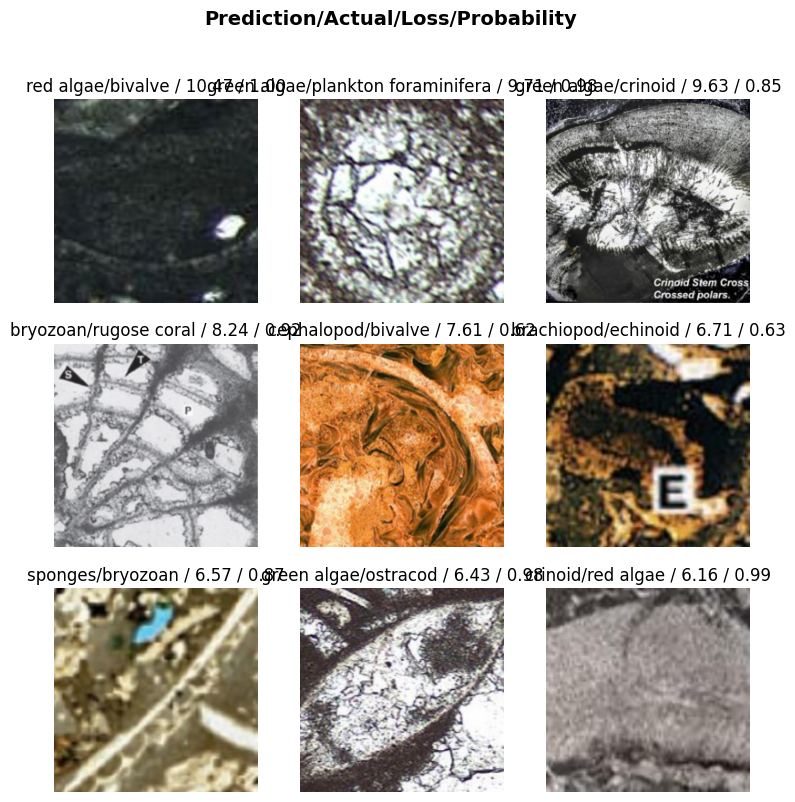

In [39]:
# Plot training/validation losses
learn.recorder.plot_loss()

# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

# Top losses (hardest-to-classify images)
interp.plot_top_losses(9, nrows=3, figsize=(9,9))


In [47]:
learn.export("best_model_export.pkl")


In [48]:
!ls -lh /content


total 99M
-rw-r--r-- 1 root root  99M Sep 28 06:50  best_model_export.pkl
drwxr-xr-x 7 root root 4.0K Sep 28 06:51  Carbonate-Image-Classification-1
-rw-r--r-- 1 root root  61K Sep 28 06:48 'planktonz (1).jpg'
-rw-r--r-- 1 root root  61K Sep 28 06:49 'planktonz (2).jpg'
-rw-r--r-- 1 root root  61K Sep 28 06:48  planktonz.jpg
drwxr-xr-x 1 root root 4.0K Sep 25 13:37  sample_data


Saving planktonz.jpg to planktonz (4).jpg


load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.


Predicted Class: cephalopod
Probability: 0.9168


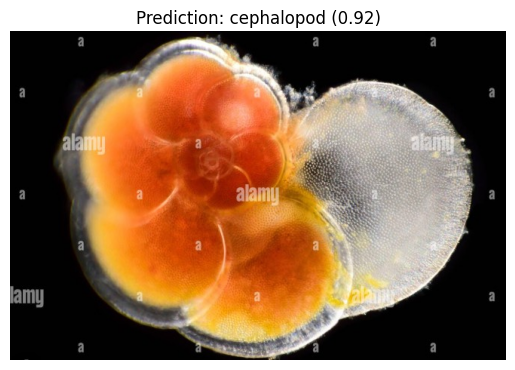

In [50]:
from google.colab import files
from fastai.vision.all import *

# Step 1: Upload your test image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]   # get filename

# Step 2: Load the trained model (must have exported it earlier)
learn_inf = load_learner("/content/best_model_export.pkl")

# Step 3: Predict
img = PILImage.create(img_path)
pred_class, pred_idx, probs = learn_inf.predict(img)

print(f"Predicted Class: {pred_class}")
print(f"Probability: {probs[pred_idx]:.4f}")

# Optional: show image with prediction
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({probs[pred_idx]:.2f})")
plt.show()


